In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from dotmap import DotMap

In [4]:
PROJECT_PATH = '../'
DATA_DIR = "/home/swei20/AE/data/"
# DATA_PATH = '/scratch/ceph/swei20/data/ae/dataset/test'
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
SZALAY_PATH = os.path.join("/scratch/ceph/szalay/swei20/AE", 'pca.h5')
sys.path.insert(0, PROJECT_PATH)

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [11]:
import tensorflow as tf
# tf.enable_v2_behavior()
gpus = tf.config.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### load data

In [7]:
with h5py.File(PCA_PATH, 'r') as f:
#     flux = f['flux'][()]
#     flux_idx = f['flux_idx'][()]
#     Fe_H = f['Fe_H'][()]
#     log_g = f['log_g'][()]
#     O_M = f['O_M'][()]
#     C_M = f['C_M'][()]
#     T_eff = f['T_eff'][()]
    wave = f['wave'][()]
    eigv = f['flux_eigv'][()]

In [8]:
DATA_PATH = os.path.join(DATA_DIR, 'pc32.h5')
with h5py.File(DATA_PATH, 'r') as f:
#     flux = f['flux'][()]
#     flux32m = f['flux32m'][()]
    flux32ms = f['flux32ms'][()]

### Model Config

In [147]:
config_dict ={
    "data": {
      "dir":"./data",
      "filename": "pc32.h5",
      "train": "flux32ms"
    },
    "model":{
      "aug": 1,
      "name": "eval",
      "input_dim": 32,
      "latent_dim": 8,
      "hidden_dims": [128, 64],
      "dropout": 0.0,
      "lr": 0.003,
      "reg1": 0.00001,
      "loss": "mse",
      "opt": "adam",
      "batchnorm": 0,
      "act_in": "leaky",
      "act_em": "leaky",
      "act_hd": "leaky"
    },
    "trainer":{
      "epoch": 1,
      "batch_size": 16,
      "validation_split":0.3,
      "verbose": 1,
      "save": 0
    },
    "callbacks":{
        "checkpoint_monitor": "val_loss",
        "checkpoint_mode": "min"
    }
}
config = DotMap(config_dict)`

### VAE

In [17]:
from tensorflow import keras
import tensorflow.keras.layers as kl
import tensorflow.keras.regularizers as kr
import tensorflow.keras.activations as ka
from tensorflow.keras import Sequential as ks
from tensorflow.keras import optimizers as ko
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError

In [18]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = kl.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = kl.Dense(latent_dim)(h)
z_log_sigma = kl.Dense(latent_dim)(h)

In [21]:
from tensorflow.keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = kl.Lambda(sampling)([z_mean, z_log_sigma])

In [26]:
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = kl.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = kl.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [27]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [29]:
from tensorflow.keras.datasets import mnist

In [38]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [48]:
vae.fit(x_train, x_train,
        epochs=30,
        batch_size=32,
        verbose=0,
        validation_data=(x_test, x_test))

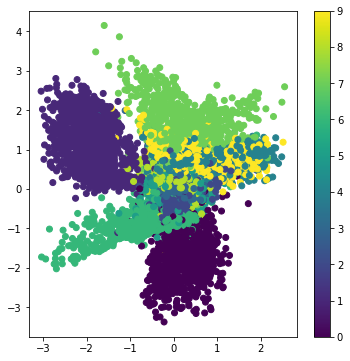

In [49]:
x_test_encoded = encoder.predict(x_test)[-1]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

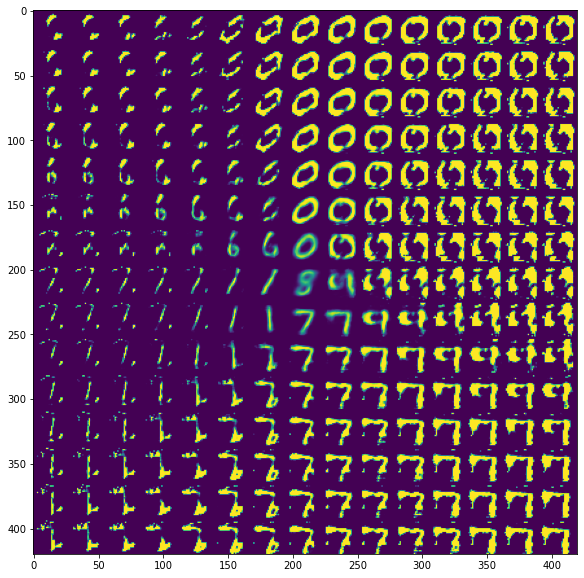

In [50]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

### On pcs

In [76]:
original_dim = 32
intermediate_dim = 64
latent_dim = 5

inputs = keras.Input(shape=(original_dim,))
h = kl.Dense(intermediate_dim, activation='relu')(inputs)
h = kl.LeakyReLU()(h)
z_mean = kl.Dense(latent_dim)(h)
z_log_sigma = kl.Dense(latent_dim)(h)

In [77]:
from tensorflow.keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.01)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = kl.Lambda(sampling)([z_mean, z_log_sigma])

In [78]:
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = kl.Dense(intermediate_dim)(latent_inputs)
x = kl.LeakyReLU()(x)
outputs = kl.Dense(original_dim, activation='linear')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [79]:
# reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss = keras.losses.mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [80]:
x_train=flux32ms

In [81]:
x_train.shape

(116614, 32)

In [82]:
vae.fit(x_train, x_train,
        epochs=30,
        batch_size=256,
        validation_split=0.3
#         verbose=0
       )

Epoch 1/30
2551/2551 [==============================] - 6s 2ms/step - loss: 1.6163 - val_loss: 3.0046
Epoch 2/30
2551/2551 [==============================] - 6s 2ms/step - loss: 0.4862 - val_loss: 2.0505
Epoch 3/30
2551/2551 [==============================] - 7s 3ms/step - loss: 0.3665 - val_loss: 1.8625
Epoch 4/30
2551/2551 [==============================] - 6s 2ms/step - loss: 0.3175 - val_loss: 1.9086
Epoch 5/30
2551/2551 [==============================] - 6s 2ms/step - loss: 0.2923 - val_loss: 1.5926
Epoch 6/30
2551/2551 [==============================] - 6s 3ms/step - loss: 0.2736 - val_loss: 1.5150
Epoch 7/30
2551/2551 [==============================] - 7s 3ms/step - loss: 0.2536 - val_loss: 1.5093
Epoch 8/30
2551/2551 [==============================] - 6s 2ms/step - loss: 0.2369 - val_loss: 1.3040
Epoch 9/30
2551/2551 [==============================] - 6s 2ms/step - loss: 0.2233 - val_loss: 1.4321
Epoch 10/30
2551/2551 [==============================] - 6s 2ms/step - loss: 0.215

In [84]:
df_para = pd.read_csv("/home/swei20/AE/data/para.csv")

In [87]:
df_para

,Unnamed: 0,Fe,Te,Lg,CM,OM,p1,p2,FeH,Teff,Logg,C_M,O_M,p3
0,0,0,0,0,1,0,-30.338438,2.195663,-2.50,3500.0,0.0,-0.50,-0.25,-5.001692
1,1,0,0,0,1,1,-32.764657,2.281114,-2.50,3500.0,0.0,-0.50,0.00,-5.436010
2,2,0,0,0,1,2,-35.870359,2.474615,-2.50,3500.0,0.0,-0.50,0.25,-5.925817
3,3,0,0,0,1,3,-39.618324,2.673175,-2.50,3500.0,0.0,-0.50,0.50,-6.343921
4,4,0,0,0,2,0,-31.107103,2.169074,-2.50,3500.0,0.0,-0.25,-0.25,-5.149027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116609,116609,13,60,10,4,3,-4.104047,-5.056857,0.75,30000.0,5.0,0.25,0.50,1.422326
116610,116610,13,60,10,5,0,-3.438580,-4.956540,0.75,30000.0,5.0,0.50,-0.25,1.236275
116611,116611,13,60,10,5,1,-3.618532,-4.968871,0.75,30000.0,5.0,0.50,0.00,1.290465
116612,116612,13,60,10,5,2,-3.835860,-4.973086,0.75,30000.0,5.0,0.50,0.25,1.356232


In [92]:
df3d = df_para[(df_para['C_M']==0) & (df_para["O_M"]==0)]
para3d_idx = df3d.index

In [90]:
x_test = x_train[para3d_idx]

In [96]:
x_test_encoded.shape

(6336, 5)

In [98]:
latent_dim=5

In [102]:
df3d

,Unnamed: 0,Fe,Te,Lg,CM,OM,p1,p2,FeH,Teff,Logg,C_M,O_M,p3
9,9,0,0,0,3,1,-33.800363,2.131085,-2.50,3500.0,0.0,0.0,0.0,-5.416027
29,29,0,0,1,3,1,-40.023893,2.926853,-2.50,3500.0,0.5,0.0,0.0,-5.883087
49,49,0,0,2,3,1,-45.953753,3.805571,-2.50,3500.0,1.0,0.0,0.0,-7.035720
69,69,0,0,3,3,1,-45.529586,4.299167,-2.50,3500.0,1.5,0.0,0.0,-8.048748
85,85,0,0,4,3,1,-43.820162,4.573155,-2.50,3500.0,2.0,0.0,0.0,-8.223677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116526,116526,13,60,6,3,1,4.762276,0.634553,0.75,30000.0,3.0,0.0,0.0,-1.736324
116543,116543,13,60,7,3,1,-2.134988,-2.545087,0.75,30000.0,3.5,0.0,0.0,0.626786
116563,116563,13,60,8,3,1,-3.084944,-4.021800,0.75,30000.0,4.0,0.0,0.0,0.970508
116583,116583,13,60,9,3,1,-3.481322,-4.756228,0.75,30000.0,4.5,0.0,0.0,1.126319


In [115]:
dfen = pd.DataFrame(data=x_test_encoded, columns=[f"e{i}" for i in range(1, 1+ latent_dim)], index=para3d_idx)

In [116]:
dfen

,e1,e2,e3,e4,e5
9,0.077248,0.119365,0.052290,-0.011043,0.133454
29,0.096986,0.122403,0.113249,0.018014,0.177551
49,0.094719,0.166815,0.137881,0.037034,0.215855
69,0.070226,0.133858,0.159843,0.063770,0.227439
85,0.056899,0.121778,0.145533,0.106329,0.207667
...,...,...,...,...,...
116526,-0.340187,-0.132177,-0.097731,0.074543,-0.008687
116543,-0.207805,-0.125385,-0.033499,0.051598,-0.075277
116563,-0.149857,-0.075186,-0.022876,0.049632,-0.094282
116583,-0.137299,-0.061816,-0.041954,0.053959,-0.120538


In [117]:
dfen = pd.concat([dfen, df3d], axis=1)

In [118]:
dfen

,e1,e2,e3,e4,e5,Unnamed: 0,Fe,Te,Lg,CM,OM,p1,p2,FeH,Teff,Logg,C_M,O_M,p3
9,0.077248,0.119365,0.052290,-0.011043,0.133454,9,0,0,0,3,1,-33.800363,2.131085,-2.50,3500.0,0.0,0.0,0.0,-5.416027
29,0.096986,0.122403,0.113249,0.018014,0.177551,29,0,0,1,3,1,-40.023893,2.926853,-2.50,3500.0,0.5,0.0,0.0,-5.883087
49,0.094719,0.166815,0.137881,0.037034,0.215855,49,0,0,2,3,1,-45.953753,3.805571,-2.50,3500.0,1.0,0.0,0.0,-7.035720
69,0.070226,0.133858,0.159843,0.063770,0.227439,69,0,0,3,3,1,-45.529586,4.299167,-2.50,3500.0,1.5,0.0,0.0,-8.048748
85,0.056899,0.121778,0.145533,0.106329,0.207667,85,0,0,4,3,1,-43.820162,4.573155,-2.50,3500.0,2.0,0.0,0.0,-8.223677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116526,-0.340187,-0.132177,-0.097731,0.074543,-0.008687,116526,13,60,6,3,1,4.762276,0.634553,0.75,30000.0,3.0,0.0,0.0,-1.736324
116543,-0.207805,-0.125385,-0.033499,0.051598,-0.075277,116543,13,60,7,3,1,-2.134988,-2.545087,0.75,30000.0,3.5,0.0,0.0,0.626786
116563,-0.149857,-0.075186,-0.022876,0.049632,-0.094282,116563,13,60,8,3,1,-3.084944,-4.021800,0.75,30000.0,4.0,0.0,0.0,0.970508
116583,-0.137299,-0.061816,-0.041954,0.053959,-0.120538,116583,13,60,9,3,1,-3.481322,-4.756228,0.75,30000.0,4.5,0.0,0.0,1.126319


In [111]:
import seaborn as sns

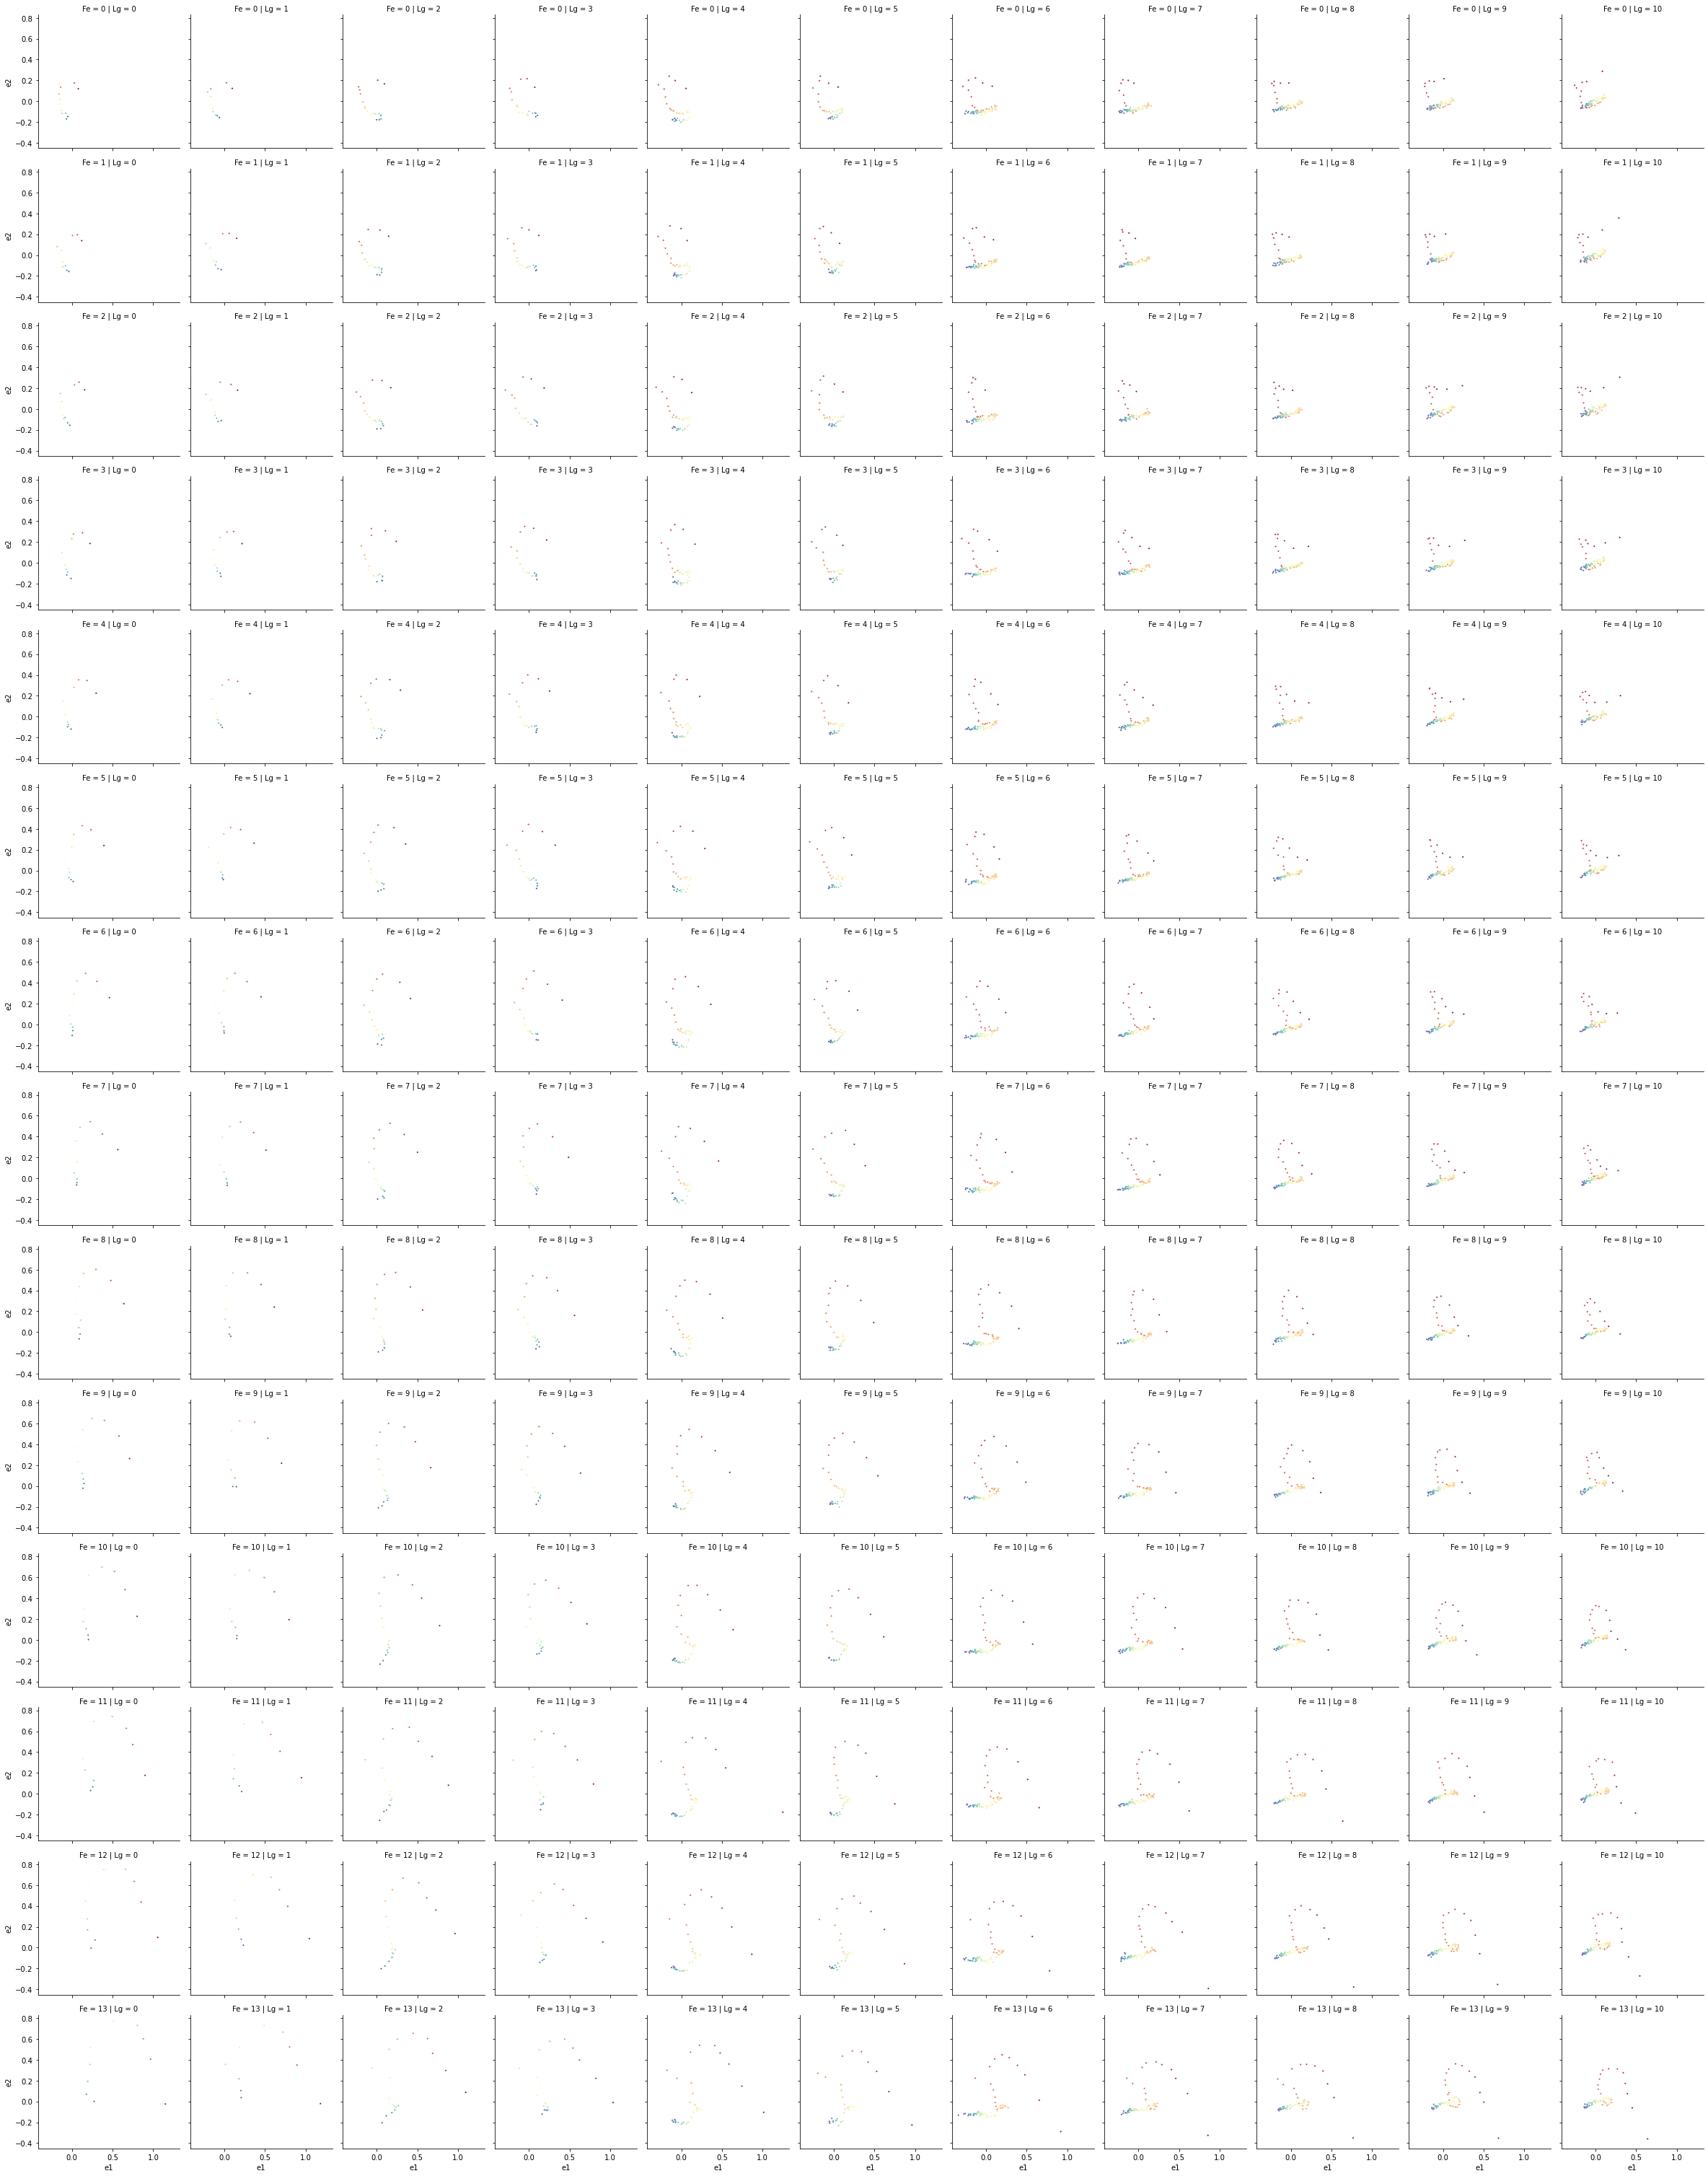

In [128]:
fg=sns.FacetGrid(dfen, col="Lg", row="Fe")
fg.map_dataframe(sns.scatterplot, "e1", "e2", hue="Te", palette="Spectral", s=5)

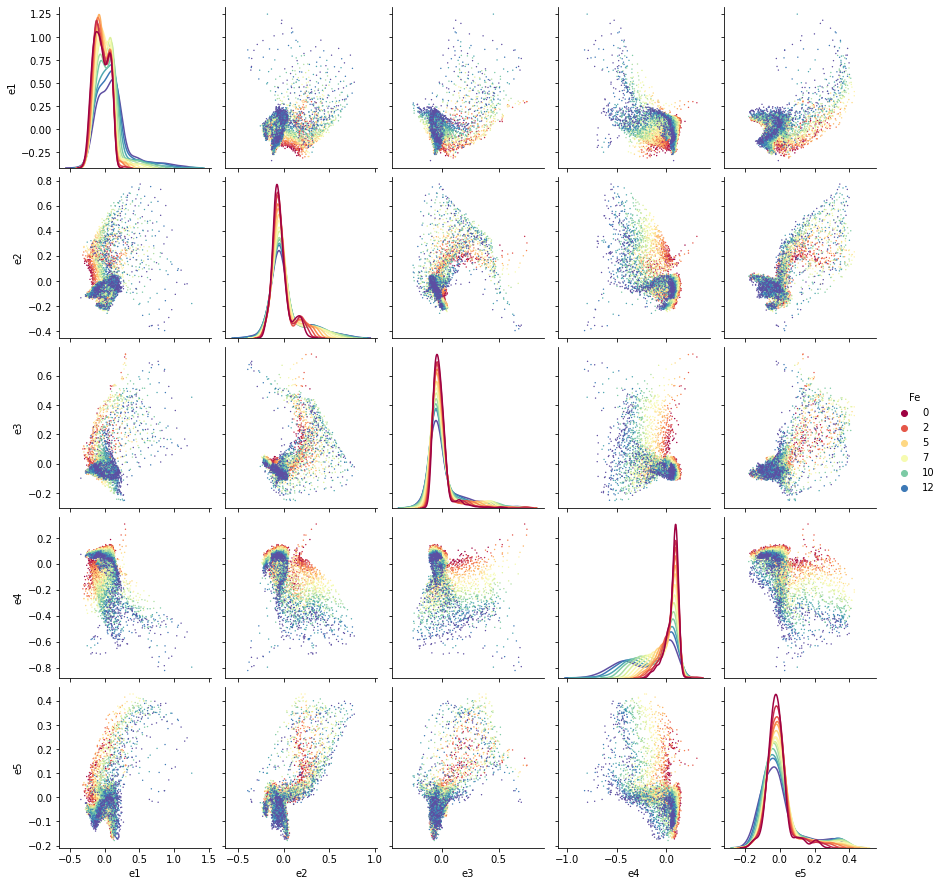

In [142]:
sns.pairplot(
    dfen,
    x_vars=[f"e{i}" for i in range(1,6)],
    y_vars=[f"e{i}" for i in range(1,6)],
    hue="Fe",
    plot_kws=dict(marker="o", s=2, edgecolor="none"),
    diag_kws=dict(fill=False),
    palette="Spectral"
)

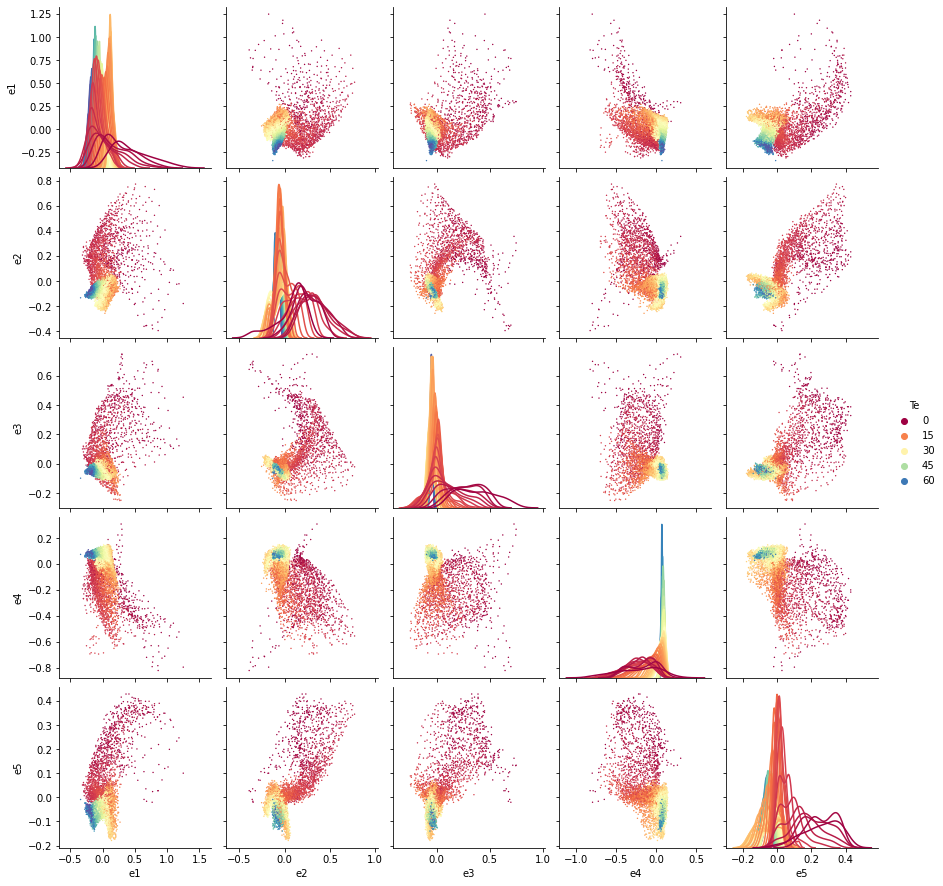

In [143]:
sns.pairplot(
    dfen,
    x_vars=[f"e{i}" for i in range(1,6)],
    y_vars=[f"e{i}" for i in range(1,6)],
    hue="Te",
    plot_kws=dict(marker="o", s=2, edgecolor="none"),
    diag_kws=dict(fill=False),
    palette="Spectral"
)

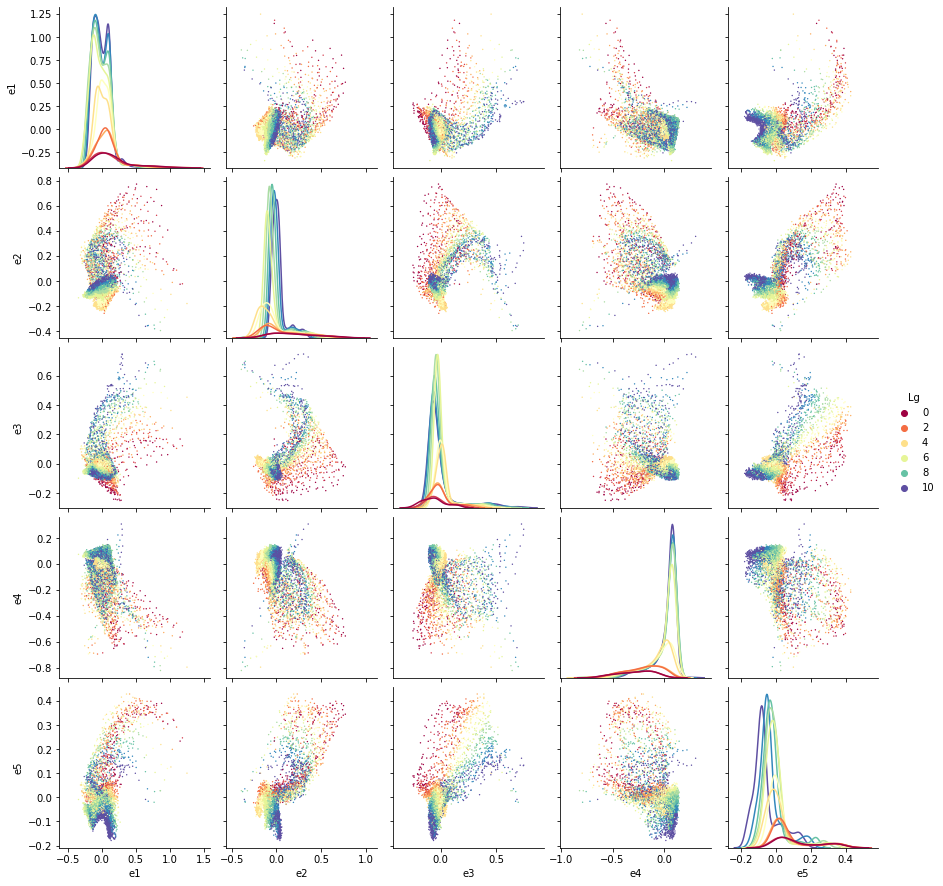

In [144]:
sns.pairplot(
    dfen,
    x_vars=[f"e{i}" for i in range(1,6)],
    y_vars=[f"e{i}" for i in range(1,6)],
    hue="Lg",
    plot_kws=dict(marker="o", s=2, edgecolor="none"),
    diag_kws=dict(fill=False),
    palette="Spectral"
)

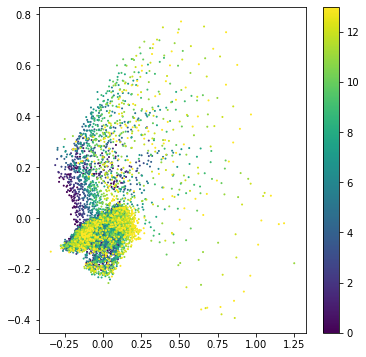

In [94]:
x_test_encoded = encoder.predict(x_test)[-1]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=df3d["Fe"], s=1)
plt.colorbar()
plt.show()

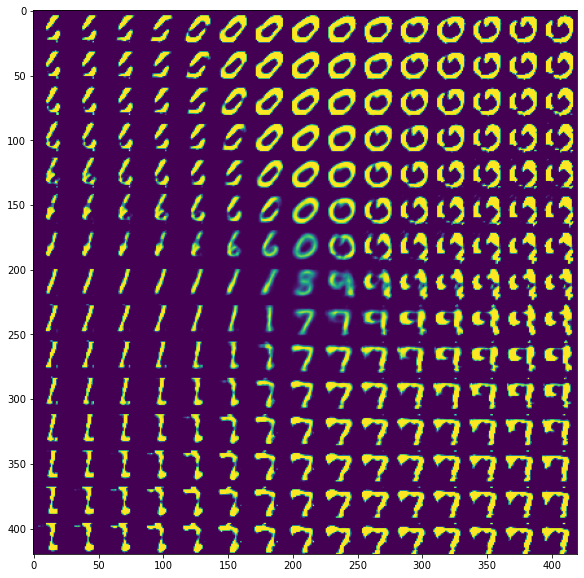

In [44]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [238]:
from ae.model.vae_model import VAEModel
from ae.trainer.simple_ae_trainer import SimpleAETrainer

In [239]:
config_dict ={
    "data": {
      "dir":"./data",
      "filename": "pc32.h5",
      "train": "flux32ms"
    },
    "model":{
      "aug": 1,
      "name": "eval",
      "input_dim": 32,
      "latent_dim": 5,
      "hidden_dims": [128, 64],
      "dropout": 0.0,
      "lr": 0.003,
      "reg1": 0.00001,
      "loss": "mse",
      "opt": "adam",
      "batchnorm": 0,
      "act_in": "leaky",
      "act_em": "leaky",
      "act_hd": "leaky"
    },
    "trainer":{
      "epoch": 50,
      "batch_size": 16,
      "validation_split":0.3,
      "verbose": 0,
      "save": 0
    },
    "callbacks":{
        "checkpoint_monitor": "val_loss",
        "checkpoint_mode": "min"
    }
}
config = DotMap(config_dict)

In [240]:
mm = VAEModel()

In [241]:
mm.build_model(config)

In [242]:
tt = SimpleAETrainer(mm, config)

In [203]:
data = (x_train, x_train)
tt.train(data)

Epoch 1/50
5102/5102 [==============================] - 16s 3ms/step - loss: 0.5612 - mean_squared_error: 0.0144 - val_loss: 1.8854 - val_mean_squared_error: 0.0529
Epoch 2/50
5102/5102 [==============================] - 16s 3ms/step - loss: 0.3659 - mean_squared_error: 0.0097 - val_loss: 0.9659 - val_mean_squared_error: 0.0240
Epoch 3/50
5102/5102 [==============================] - 16s 3ms/step - loss: 0.2093 - mean_squared_error: 0.0054 - val_loss: 1.2757 - val_mean_squared_error: 0.0366
Epoch 4/50
5102/5102 [==============================] - 15s 3ms/step - loss: 0.2228 - mean_squared_error: 0.0058 - val_loss: 1.5266 - val_mean_squared_error: 0.0446
Epoch 5/50
5102/5102 [==============================] - 15s 3ms/step - loss: 0.2361 - mean_squared_error: 0.0062 - val_loss: 1.3273 - val_mean_squared_error: 0.0351
Epoch 6/50
5102/5102 [==============================] - 16s 3ms/step - loss: 0.1565 - mean_squared_error: 0.0038 - val_loss: 1.3052 - val_mean_squared_error: 0.0377
Epoch 7/50

In [205]:
x_test.shape

(6336, 32)

In [209]:
vae_pred = mm.encoder.predict(x_test)[-1]

In [210]:
vae_pred.shape

(6336, 8)

In [218]:
df3d

,Unnamed: 0,Fe,Te,Lg,CM,OM,p1,p2,FeH,Teff,Logg,C_M,O_M,p3
9,9,0,0,0,3,1,-33.800363,2.131085,-2.50,3500.0,0.0,0.0,0.0,-5.416027
29,29,0,0,1,3,1,-40.023893,2.926853,-2.50,3500.0,0.5,0.0,0.0,-5.883087
49,49,0,0,2,3,1,-45.953753,3.805571,-2.50,3500.0,1.0,0.0,0.0,-7.035720
69,69,0,0,3,3,1,-45.529586,4.299167,-2.50,3500.0,1.5,0.0,0.0,-8.048748
85,85,0,0,4,3,1,-43.820162,4.573155,-2.50,3500.0,2.0,0.0,0.0,-8.223677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116526,116526,13,60,6,3,1,4.762276,0.634553,0.75,30000.0,3.0,0.0,0.0,-1.736324
116543,116543,13,60,7,3,1,-2.134988,-2.545087,0.75,30000.0,3.5,0.0,0.0,0.626786
116563,116563,13,60,8,3,1,-3.084944,-4.021800,0.75,30000.0,4.0,0.0,0.0,0.970508
116583,116583,13,60,9,3,1,-3.481322,-4.756228,0.75,30000.0,4.5,0.0,0.0,1.126319


In [223]:
_,s,v = np.linalg.svd(vae_pred)

In [235]:
from ae.eval.plot_util import *

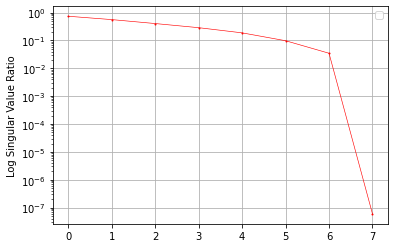

In [225]:
plot_s(s)

In [226]:
v.shape

(8, 8)

In [227]:
v = v.T

In [228]:
vae_pred5 = vae_pred.dot(v[:,:5])

In [229]:
vae_pred5.shape

(6336, 5)

In [231]:
dfen8 = pd.DataFrame(data= vae_pred5, columns = [f"e{i}" for i in range(1, 6)], index = df3d.index)

In [232]:
dfen8_all = pd.concat([dfen8, df3d], axis=1)

In [233]:
dfen8_all

,e1,e2,e3,e4,e5,Unnamed: 0,Fe,Te,Lg,CM,OM,p1,p2,FeH,Teff,Logg,C_M,O_M,p3
9,0.000437,0.043403,-0.040760,0.098956,-0.064705,9,0,0,0,3,1,-33.800363,2.131085,-2.50,3500.0,0.0,0.0,0.0,-5.416027
29,0.009381,0.052393,-0.057978,0.089407,-0.052291,29,0,0,1,3,1,-40.023893,2.926853,-2.50,3500.0,0.5,0.0,0.0,-5.883087
49,0.010549,0.062360,-0.083498,0.079656,-0.057761,49,0,0,2,3,1,-45.953753,3.805571,-2.50,3500.0,1.0,0.0,0.0,-7.035720
69,-0.005295,0.060512,-0.099817,0.073608,-0.061479,69,0,0,3,3,1,-45.529586,4.299167,-2.50,3500.0,1.5,0.0,0.0,-8.048748
85,-0.016918,0.065331,-0.106611,0.065889,-0.065906,85,0,0,4,3,1,-43.820162,4.573155,-2.50,3500.0,2.0,0.0,0.0,-8.223677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116526,-0.178743,0.086344,-0.126295,0.010698,-0.093594,116526,13,60,6,3,1,4.762276,0.634553,0.75,30000.0,3.0,0.0,0.0,-1.736324
116543,-0.044485,0.013956,-0.002590,0.039824,0.015827,116543,13,60,7,3,1,-2.134988,-2.545087,0.75,30000.0,3.5,0.0,0.0,0.626786
116563,-0.037256,0.007427,-0.005820,0.028850,0.026523,116563,13,60,8,3,1,-3.084944,-4.021800,0.75,30000.0,4.0,0.0,0.0,0.970508
116583,-0.036987,0.008735,-0.000882,0.028231,0.030093,116583,13,60,9,3,1,-3.481322,-4.756228,0.75,30000.0,4.5,0.0,0.0,1.126319


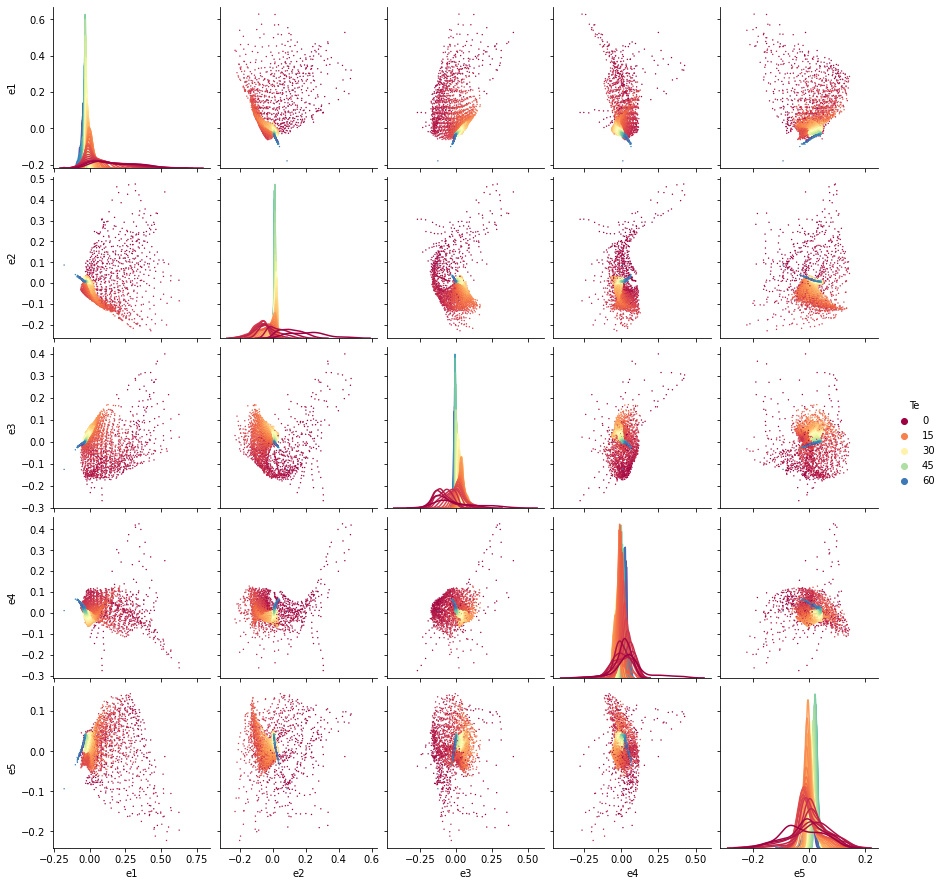

In [236]:
plot_latent_on(dfen8_all, "Te")

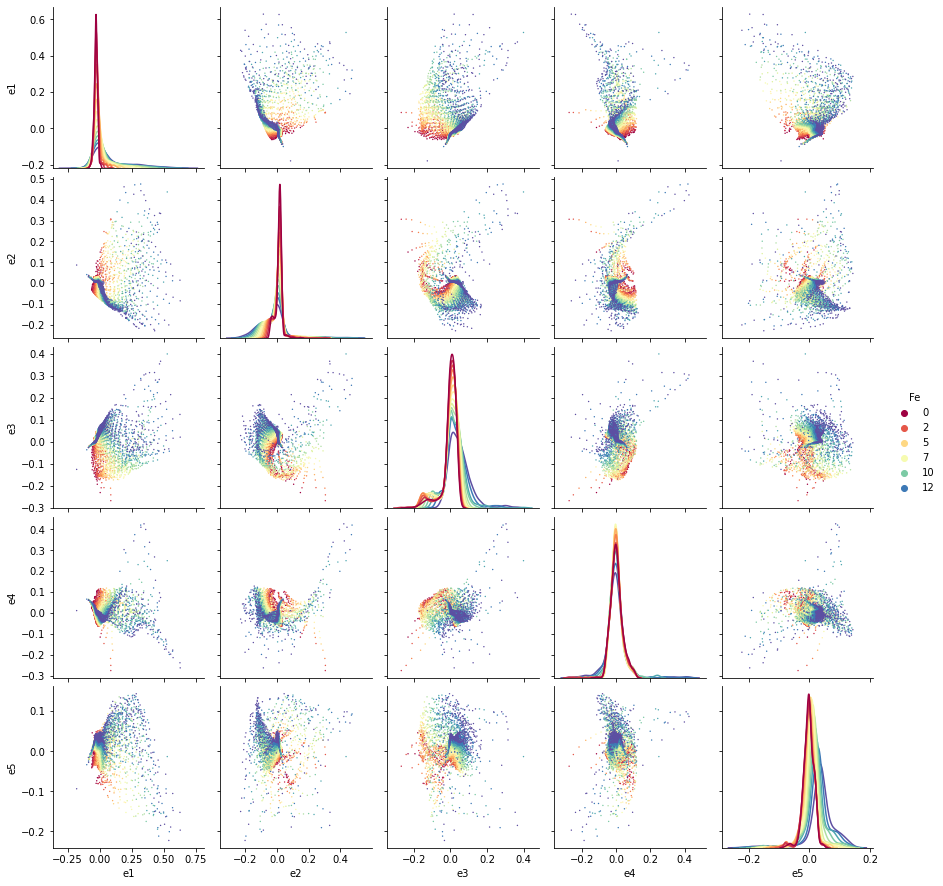

In [237]:
plot_latent_on(dfen8_all, "Fe")